In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from control import dare
import single_photons.utils.constants as ct
from single_photons.utils.parameters import *
from single_photons.environment import Cavity_Particle
from single_photons.simulation.simulation_cavity import simulation_c

C:\Users\jorge\anaconda2023.3\lib\site-packages\single_photons-0.0.1-py3.10.egg\single_photons\simulation\simulation_particle.py:3: NumbaPendingDeprecationWarning: The 'pycc' module is pending deprecation. Replacement technology is being developed.

Pending Deprecation in Numba 0.57.0. For more information please see: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-the-numba-pycc-module


In [2]:
def linear(x,a,b):
    return a*x+b

def compute_optical_input(alpha_in, env, delta_t, N):
    x_in = (
    np.sqrt(env.__kappa__)
    * delta_t
    * (
        env.__optical_noise__ * np.random.normal() / np.sqrt(delta_t)
        + np.conjugate(alpha_in)
        + alpha_in
    )
    )
    y_in = (
        1j
        * np.sqrt(env.__kappa__)
        * delta_t
        * (
            env.__optical_noise__ * np.random.normal() / np.sqrt(delta_t)
            + np.conjugate(alpha_in)
            - alpha_in
        )
    )
    optical_input = 1j*np.zeros((4, N))
    optical_input[0, :] = x_in
    optical_input[1, :] = y_in    
    return optical_input

def create_pulse(photon_number, pulse_multiplicity, period, delta_t, length,linewidth):
    pulse_amplitude = photon_number**2/pulse_multiplicity
    start_ref = 200*period/delta_t
    centers = []
    for i in range(pulse_multiplicity):
        centers.append(start_ref + (i+1)/pulse_multiplicity * int(t.shape[0]/2))
    round_trip_time = 2*length/ct.c
    trips = 1/(2*np.pi*round_trip_time*linewidth)
    pulse_width = trips*round_trip_time/delta_t
    for i in range(pulse_multiplicity):
        if i==0:
            alpha_in = pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) *\
                                (np.exp(-((np.arange(0,N,1)-centers[i])/(2*pulse_width**2))**2))
        else:
            alpha_in = alpha_in + pulse_amplitude/(np.sqrt(delta_t) * np.power(np.pi*pulse_width**2,1/4)) *\
                                (np.exp(-((np.arange(0,N,1)-centers[i])/(2*pulse_width**2))**2))
    optical_input = compute_optical_input(alpha_in,env,delta_t,N)
    return optical_input, centers, pulse_width

def compute_phonons(estimations, cov_matrix, centers, pulse_width, step=100):
    estimates = estimations[::control_step]
    sampled_cov_matrix = [el[0:,0:] for el in cov_matrix[:estimates.shape[0]]]
    N = len(sampled_cov_matrix)
    phonons = np.zeros(int(estimates.shape[0]/step)-1)
    SNR = 0
    for i in range(1, int(estimates.shape[0]/step)):
        averaged = estimates[(i-1)*step:i*step, 0:].mean(axis=0)
        second_moments = sampled_cov_matrix[i]+np.power(averaged,2)
        phonons[i-1] = np.trace(second_moments)/4-0.5
    for pulse_center in centers:
        low_crop = int((pulse_center - max([100*pulse_width,period]))/(step*control_step))
        high_crop = int((pulse_center + max([100*pulse_width,period]))/(step*control_step))
        crop_phonons = phonons[low_crop:high_crop]
        size = crop_phonons.shape[0]
        start_ref = int(200*period/(delta_t*step*control_step))
        reference = phonons[start_ref:size + start_ref]
        SNR = SNR + np.sqrt(np.mean(np.square(crop_phonons)))/np.sqrt(np.mean(np.square(reference)))
    
    '''
    plt.plot(1e3*t[::control_step][::step][start_ref:phonons.shape[0]],phonons[start_ref:])
    plt.ylabel('Phonons')
    plt.xlabel('Time [ms]')
    plt.figure()
    plt.plot(1e3*t[::control_step][::step][low_crop:high_crop],crop_phonons)
    plt.title('Crop around pulse')
    plt.ylabel('Phonons')
    plt.xlabel('Time [ms]')
    plt.figure()
    plt.title('Reference')
    plt.ylabel('Phonons')
    plt.xlabel('Time [ms]')
    plt.plot(1e3*t[::control_step][::step][start_ref:start_ref+size],reference)'''
    return [phonons, SNR, start_ref, size]

def compute_times(phonons,control_step,step,start_ref,size):
    window = 1e-3/(delta_t*control_step*step)
    idx_max = 0
    M = 0
    phonons = phonons[start_ref:]
    mean = np.mean(phonons[start_ref:start_ref+size])
    for idx in range(phonons.shape[0]):
        if phonons[idx] > M:
            idx_max = idx
            M = phonons[idx]
    idx_left = idx_max
    idx_right = idx_max
    while 1:
        c = 0
        if phonons[idx_left] > mean + (M-mean)/np.e:
            idx_left = idx_left - 1
            c = 1
        if phonons[idx_right] > mean + (M-mean)/np.e:
            idx_right = idx_right + 1
            c = 1
        if c == 0:
            break
    rising = (idx_max-idx_left)*control_step*step*delta_t
    acommodation = (idx_right-idx_max)*control_step*step*delta_t
    return rising,acommodation

In [3]:
omega = 2*np.pi*1e5
period = 2*np.pi/omega
t = np.arange(0, 700*period, period/2000)
delta_t = np.diff(t)[0]
N = t.shape[0]

rho = 2200
index_refraction = 1.4440
T = 293
p = 1e-6
radius = 75e-9
wavelength = 1.064e-6
power = 300e-3
eta_detection = 0.178
control_step = int(30e-9/delta_t) 
fs = 1/(control_step*delta_t)
cavity_waist = 100e-6
cavity_length = 50e-3
tweezer_waist = 0.6e-6
detuning_ratio = 0.25 
cavity_linewidth_ratio = 0.5
optomechanical_coupling_ratio = 1.5 #with respect to g_0 defined below

gamma, omega, ba_force, std_detection, std_z, g_cs, detuning, cavity_linewidth =\
compute_parameters_simulation_cavity(power, wavelength, tweezer_waist, radius, p, fs, eta_detection, 
                                     cavity_length, cavity_waist, detuning_ratio, cavity_linewidth_ratio,
                                    T = T, rho = rho, index_refraction = index_refraction)

coupling = (1/(4*np.pi))*(ba_force**2)
g_0 = 0.19*omega

env = Cavity_Particle(
    omega,
    gamma,
    detuning,
    cavity_linewidth,
    optomechanical_coupling_ratio*g_0,
    coupling,
    radius=radius,
    eta_detection=eta_detection,
    T=T
)
variance_process = env.thermal_force_std**2 + env.backaction_std**2
std_detection = std_detection/env.zp_x

In [4]:
Q = np.array(
    [
        [(env.__optical_noise__**2)*cavity_linewidth, 0, 0, 0],
        [0, (env.__optical_noise__**2)*cavity_linewidth, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, variance_process],
    ]
)*control_step*delta_t/2
R = np.array([[np.power(std_detection, 2)]])

g_fb = 5*omega
Ad = scipy.linalg.expm(env.A *control_step*delta_t)
Bd = env.B * delta_t * control_step
cost_states = np.array([[omega/2, 0, 0, 0],
                        [0, omega/2, 0, 0],
                        [0, 0, omega/2, 0],
                        [0, 0, 0, omega/2]
                       ])
X, L, G_fb = dare(Ad, Bd, cost_states, omega/(g_fb**2))

In [64]:
max_mean_photons = 102
numbers = np.linspace(0,5,10)
widths = np.linspace(0.2,5.2,10)
multiplicity = 1
rising = []
acommodation = []
SNR = []
step = 50
for width in widths:
    SNRs = []
    risings = []
    acommodations = []
    for photon_number in tqdm(numbers):
        optical_input, centers, pulse_width = create_pulse(photon_number,multiplicity,period,delta_t,cavity_length,width*cavity_linewidth_ratio*omega)
        x0 = 0
        P0 = ct.kb*T/(ct.hbar*omega)
        new_states, measured_states, estimated_states, cov_aposteriori, controls = simulation_c(
            env.A,
            env.B, 
            optical_input,
            env.thermal_force_std,
            env.backaction_std, 
            std_detection, 
            eta_detection,
            x0, 
            P0, 
            Ad, 
            Bd, 
            env.C, 
            env.G,
            G_fb,
            Q, 
            R, 
            delta_t, 
            control_step, 
            N
        )
        ans = compute_phonons(estimated_states,cov_aposteriori,centers,pulse_width,step = step)
        SNRs.append(ans[1])
        rise, acomm = compute_times(ans[0],control_step,step,ans[2],ans[3])
        risings.append(rise)
        acommodations.append(acomm)
    SNR.append(SNRs)
    rising.append(risings)
    acommodation.append(acommodations)
    
    #plt.plot(1e3*t[::control_step][::step][ans[2]:ans[0].shape[0]],ans[0][ans[2]:])
    #plt.ylabel('Phonons')
    #plt.xlabel('Time [ms]')
    #print(SNR)

  0%|                                                                                           | 0/10 [00:00<?, ?it/s]C:\Users\jorge\AppData\Local\Temp\ipykernel_12968\2763514401.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  phonons[i-1] = np.trace(second_moments)/4-0.5
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [01:27<00:00,  8.72s/it]


Text(0, 0.5, 'Rising and acommodation times [$\\mu$s]')

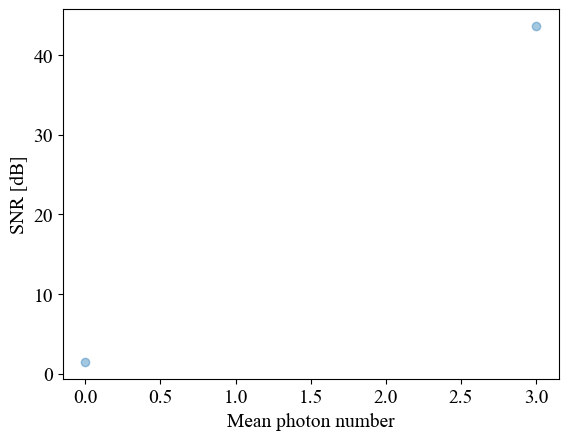

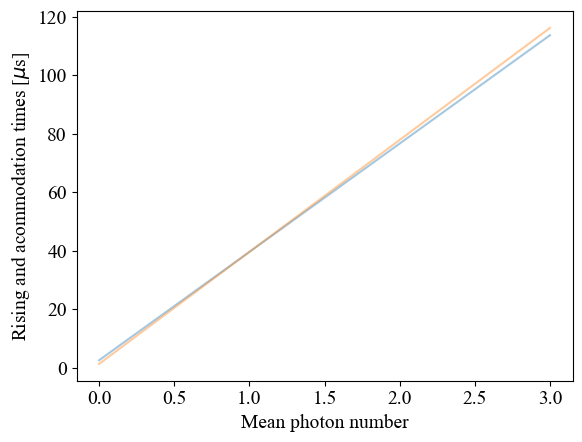

In [7]:
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 14
'''
plt.scatter(numbers,10*np.log(SNR),alpha = 0.4)
plt.xlabel('Mean photon number')
plt.ylabel('SNR [dB]')

plt.figure()
plt.plot(numbers,[1e6*x for x in rising],alpha = 0.4)
plt.plot(numbers,[1e6*x for x in acommodation],alpha = 0.4)
plt.xlabel('Mean photon number')
plt.ylabel(r'Rising and acommodation times [$\mu$s]')'''

In [8]:
'''x = numbers[8:]
y = np.log(SNR[8:])
ans,cov = scipy.optimize.curve_fit(linear,x,y)
plt.scatter(x,y)
plt.plot(x,model(x,ans[0],ans[1]))
print(ans)'''

ValueError: `ydata` must not be empty!

''

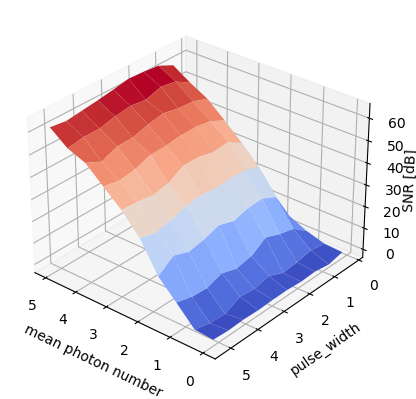

<Figure size 640x480 with 0 Axes>

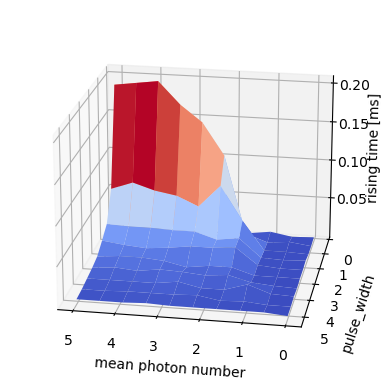

<Figure size 640x480 with 0 Axes>

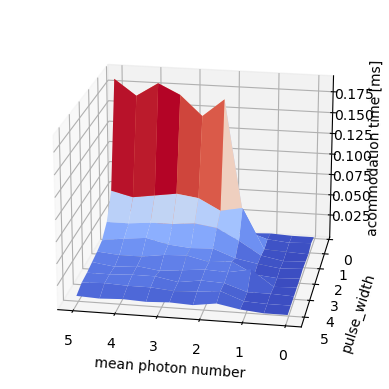

In [66]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X,Y = np.meshgrid(numbers,widths)
Z = 10*np.log(np.array(SNR))
surf = ax.plot_surface(X,Y,Z,cmap = cm.coolwarm,linewidth = 1)
ax.view_init(30,130)
ax.set_xlabel('mean photon number')
ax.set_ylabel('pulse_width')
ax.set_zlabel('SNR [dB]')
ax.zaxis.labelpad=-2.5

plt.figure()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X,Y = np.meshgrid(numbers,widths)
Z = 1e3*np.array(rising)
surf = ax.plot_surface(X,Y,Z,cmap = cm.coolwarm,linewidth = 1)
ax.view_init(20,100)
ax.set_xlabel('mean photon number')
ax.set_ylabel('pulse_width')
ax.set_zlabel('rising time [ms]')
ax.zaxis.labelpad=3

plt.figure()
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
X,Y = np.meshgrid(numbers,widths)
Z = 1e3*np.array(acommodation)
surf = ax.plot_surface(X,Y,Z,cmap = cm.coolwarm,linewidth = 1)
ax.view_init(20,100)
ax.set_xlabel('mean photon number')
ax.set_ylabel('pulse_width')
ax.set_zlabel('acommodation time [ms]')
ax.zaxis.labelpad=3
'''
plt.imshow([numbers,widths,SNR],interpolation='none',cmap=plt.cm.jet,origin='lower')
plt.colorbar()
plt.title('SNR')
plt.xlabel('mean number')
plt.ylabel('width')
plt.figure()
plt.imshow(acommodation,interpolation='none',cmap=plt.cm.jet,origin='lower')
plt.colorbar()
plt.title('Acommodation times')
plt.figure()
plt.imshow(rising,interpolation='none',cmap=plt.cm.jet,origin='lower')
plt.colorbar()
plt.title('Rising times')'''
''